<a href="https://colab.research.google.com/github/Pacifier25/ZTM-Tensorflow-course/blob/main/05_Transfer_learning_in_tensorflow_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part2: Fine tuning

In the previous notebook we covered tranfer learning feature extraction now it's time to learn about new kind of transer learning: fine tuning

In [ ]:
# Are we using a GPU?
!nvidia-smi

Wed May 19 18:53:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |   4359MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Creating helper functions

In the previous notebook we created a bunch of helper function now we could rewrite them all however it is tedious

So it is a good idea to put functions you will want to use again in a script you can download and import into your notebook(or elsewhere)

In [ ]:
! wget https://raw.githubusercontent.com/Pacifier25/ZTM-Tensorflow-course/main/helper_function/helper.py

--2021-05-19 18:53:37--  https://raw.githubusercontent.com/Pacifier25/ZTM-Tensorflow-course/main/helper_function/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10510 (10K) [text/plain]
Saving to: ‘helper.py.2’

helper.py.2         100%[===================>]  10.26K  --.-KB/s    in 0s      

2021-05-19 18:53:38 (94.3 MB/s) - ‘helper.py.2’ saved [10510/10510]



In [ ]:
# Import helper functions we're going to use
from helper import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

🔑 **Note**: If you're running this notebook in Google Colab, when it times out Colab will delete the helper_functions.py file. So to use the functions imported above, you'll have to rerun the cell.

# Let's get some data

This time we are going to see how we can use the pretrained model within tf.keras.application and apply them to our problem(recognizing image to our food)

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-05-19 18:53:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   121MB/s    in 1.3s    

2021-05-19 18:53:39 (121 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Create training and test data
train_dir = "10_food_classes_10_percent/train/"
test_dir =  "10_food_classes_10_percent/test/"

One of the main benefits of using tf.keras.prepreprocessing.image_dataset_from_directory() rather than ImageDataGenerator is that it creates a tf.data.Dataset object rather than a generator. The main advantage of this is the tf.data.Dataset API is much more efficient (faster) than the ImageDataGenerator API which is paramount for larger datasets.

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SHAPE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SHAPE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SHAPE,
                                                                label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example batch of data

for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [7.19913387e+00 2.91844821e+00 7.83169317e+00]
   [2.37914448e+01 1.54598179e+01 6.54130793e+00]
   [1.04856934e+02 9.38569336e+01 6.44282227e+01]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [3.00000000e+00 2.14263916e-01 8.87664676e-01]
   [6.51076126e+01 5.51841316e+01 4.26738205e+01]
   [1.05280533e+02 9.42805328e+01 6.48518219e+01]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [8.82673168e+00 4.20930147e+00 1.01023281e+00]
   [9.29338608e+01 8.11328354e+01 6.42756119e+01]
   [1.05505249e+02 9.17093506e+01 6.27245064e+01]]

  ...

  [[1.58000000e+02 1.80000000e+02 1.78000000e+02]
   [1

# Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is staright forward it runs our layer in sequential order but the functional API give us more flexibility to our model 

In [ ]:
# Create a model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape = (224,224,3),name = "input_shape")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)

# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D():{x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = tf.keras.activations.softmax,name = "output_layer")(x)


# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)),
                                 callbacks = [create_tensorboard_callback("transfer_learning","10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D():(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20210519-185345
Epoch 1/5
24/24 [==============================] - 18s 449ms/step - loss: 2.1584 - accuracy: 0.2431 - val_loss: 1.3649 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 8s 335ms/step - loss: 1.2652 - accuracy: 0.7265 - val_loss: 0.9314 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - 8s 336ms/step - loss: 0.8859 - accuracy: 0.8114 - val_loss: 0.7448 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 8s 334ms/step - loss: 0.7183 - accuracy: 0.8485 - val_loss: 0.6520 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 8s 333ms/step - loss: 0.6068 - accuracy: 0.8774 - val_loss: 0.6036 - val_accuracy: 0.8322


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 15s 178ms/step - loss: 0.6059 - accuracy: 0.8428


[0.6058778166770935, 0.8428000211715698]

In [ ]:
# Check layers in our base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_7
1 rescaling_6
2 normalization_6
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [ ]:
# How about we get the summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
normalization_6 (Normalization) (None, None, None, 3 7           rescaling_6[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_6[0][0]            
_____________________________________________________________________________________

In [ ]:
# summary of whole model
model_0.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


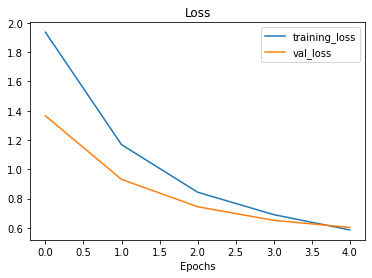

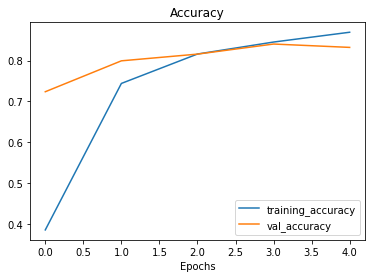

In [ ]:
plot_loss_curves(history_10_percent)

# Getting a feature vector from a trained model

Let's demonstrate the GlobalAveragePooling 2D layer

We have tensor after our model goes through base model of shape(None,7,7,1280)

But when it passes to a GlobalAveragePooling 2D layer it turns it into(None,1280)

Let's use similar shaped tensor of (1,4,4,3)and then pass it into GlobalAveragePooling 2D

`The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.`

🔑 **Note**: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")


# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


## Running a series of transfer learning experiments

We have seen incredible result in transfer learning can get only with 10% of the training data but how does it go with 1% of training data.. how about we set bunch of experiment to find out

1. model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

🔑 **Note**: throughtout all the experiment the same dataset will be used to evaluate our model... this ensures consistency across evaluation metrics

# Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-05-19 18:54:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M  97.2MB/s    in 1.3s    

2021-05-19 18:54:55 (97.2 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [ ]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           batch_size = 32,
                                                                           image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding data augmentation right into the model

To add data augmentation right in our models we can use layers inside:

* tf.keras.layers.experimental.preprocessing()

Off the top of our heads after reading the docs the benifits of using the data augmentation inside the model are:
* Preprocessing of images(augmenting them) happens on the GPU much faster rather than the CPU

* Image augmentaion usually only hapens during training so we can still
export our whole model and uses it elsewhere

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
     # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0

],name = "data_augmentation")

# Viewing our augmented layer(and see what happens to our data)

<function matplotlib.pyplot.axis>

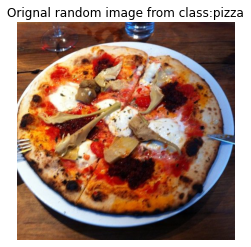

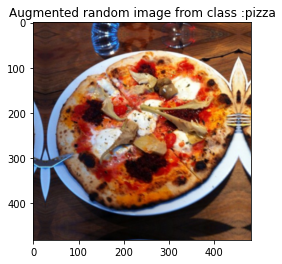

In [ ]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Orignal random image from class:{target_class}")
plt.axis(False)

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img,axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class :{target_class}")
plt.axis



# Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup the input shape and base model freezing the base model layer
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create a input layer
inputs = tf.keras.layers.Input(shape = input_shape,name = "input_shape")

# Add the data augmentaion Sequential model as a layer
x = data_augmentation(inputs)

# Give the base model inputs (after augmentation) and don't train it
x = base_model(x,training = False)

# Pool output features of base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling")(x)

# Put a dense layer
outputs = tf.keras.layers.Dense(10,activation = tf.keras.activations.softmax,name = "output_layer")(x)

# Make a model with inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps = int(0.25*len(test_data)),
                                callbacks = [create_tensorboard_callback("transfer_learning","1_percent_data_aug")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210519-185501
Epoch 1/5
3/3 [==============================] - 14s 4s/step - loss: 2.4308 - accuracy: 0.0410 - val_loss: 2.2452 - val_accuracy: 0.1250
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1253 - accuracy: 0.2549 - val_loss: 2.1365 - val_accuracy: 0.2023
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9746 - accuracy: 0.3238 - val_loss: 2.0222 - val_accuracy: 0.3125
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8371 - accuracy: 0.4857 - val_loss: 1.9282 - val_accuracy: 0.4013
Epoch 5/5
3/3 [==============================] - 6s 3s/step - loss: 1.6608 - accuracy: 0.6417 - val_loss: 1.8191 - val_accuracy: 0.4786


In [ ]:
model_1.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaluate on the test data
results_1_percent__data_aug = model_1.evaluate(test_data)
results_1_percent__data_aug

79/79 [==============================] - 15s 178ms/step - loss: 1.8399 - accuracy: 0.4532


[1.8398832082748413, 0.45320001244544983]

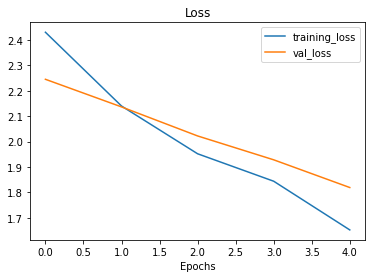

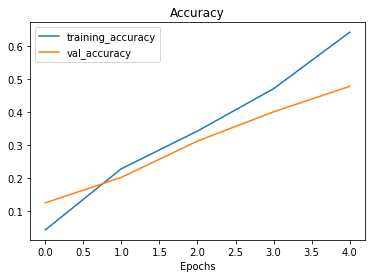

In [ ]:
plot_loss_curves(history_1_percent)

# Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir =  "10_food_classes_10_percent/test"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Build data augmentation layer
data_augmentation = tf.keras.Sequential([
        preprocessing.RandomFlip('horizontal'),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomRotation(0.2),
        # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
],name = "data_augmentaion")


# Setup the input shape
input_shape = (224,224,3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = tf.keras.layers.Input(shape = input_shape,name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x,training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10,activation = tf.keras.activations.softmax,name = "output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



In [ ]:
model_2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentaion (Sequential (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


# Creating a ModelCheckpoint callback

The modelcheckpoint callback intermediately saves our model(the full model or just the weights) during training This is useful so we can come and start where we left off

In [ ]:
# Set the checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose  = 1)

# Fit the model 2 passing in the ModelCheckpoint Callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25*len(test_data)),
                                          callbacks = [create_tensorboard_callback("transfer_learning","10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210519-185554
Epoch 1/5
24/24 [==============================] - 20s 554ms/step - loss: 2.1641 - accuracy: 0.2081 - val_loss: 1.5086 - val_accuracy: 0.6398

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 11s 437ms/step - loss: 1.4403 - accuracy: 0.6359 - val_loss: 1.0788 - val_accuracy: 0.7697

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 11s 430ms/step - loss: 1.1043 - accuracy: 0.7190 - val_loss: 0.8516 - val_accuracy: 0.7878

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 11s 448ms/step - loss: 0.9299 - accuracy: 0.7550 - val_loss: 0.7554 - val_accuracy: 0.8109

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 15s 177ms/step - loss: 0.6059 - accuracy: 0.8428


[0.6058778762817383, 0.8428000211715698]

In [ ]:
results_10_percent_data_aug  = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 14s 175ms/step - loss: 0.6867 - accuracy: 0.8172


[0.6867193579673767, 0.8172000050544739]

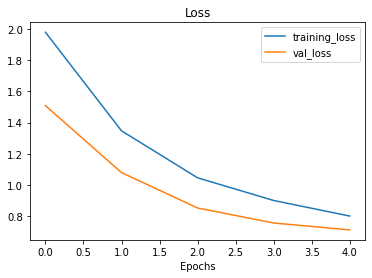

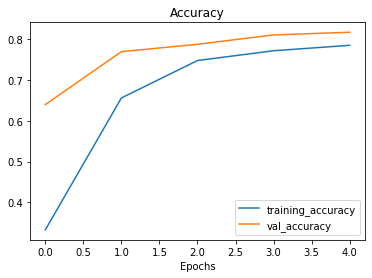

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 15s 176ms/step - loss: 0.6867 - accuracy: 0.8172


In [ ]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6867193579673767, 0.8172000050544739]

In [ ]:
loaded_weights_model_results

[0.6867194175720215, 0.8172000050544739]

In [ ]:
# Check to see if loaded model results are very close to native model results (should output True)
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


# Model 3: Fine-tuning an existing model on 10% of the data

🔑 **Note**: Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data.

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f68f519ff50> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f687b911ed0> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f68f519f590> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f6882e59610> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f687f8a0810> True


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_9 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) 

0


In [ ]:
# To begin fine tuning let's start by setting last 10 layers of our base_model.trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layers in base_model.layers[:-10]:
  layers.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),# lr is 10x lower than before for fine-tuning
                metrics = ["accuracy"])

🔑 **Note**: There's no set standard for setting the learning rate during fine-tuning, though reductions of -10x seem to work well in practice.

In [ ]:
print(len(model_2.trainable_variables))


12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epoch = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epoch,
                                               validation_data = test_data,
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],
                                               validation_steps = int(0.25*len(test_data)),
                                              callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                       experiment_name = "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210519-185744
Epoch 5/10
24/24 [==============================] - 21s 581ms/step - loss: 0.7138 - accuracy: 0.8105 - val_loss: 0.6047 - val_accuracy: 0.7928
Epoch 6/10
24/24 [==============================] - 10s 407ms/step - loss: 0.5732 - accuracy: 0.8392 - val_loss: 0.5193 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 11s 426ms/step - loss: 0.4871 - accuracy: 0.8675 - val_loss: 0.5081 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 11s 443ms/step - loss: 0.4486 - accuracy: 0.8597 - val_loss: 0.5357 - val_accuracy: 0.8076
Epoch 9/10
24/24 [==============================] - 11s 464ms/step - loss: 0.4378 - accuracy: 0.8684 - val_loss: 0.5087 - val_accuracy: 0.8174
Epoch 10/10
24/24 [==============================] - 11s 448ms/step - loss: 0.3379 - accuracy: 0.9083 - val_loss: 0.4997 - val_accuracy: 0.8207


In [ ]:
# Evaluate the model on the test data
result_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 14s 175ms/step - loss: 0.4813 - accuracy: 0.8348


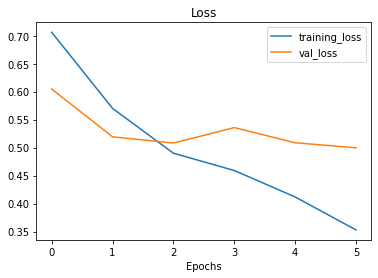

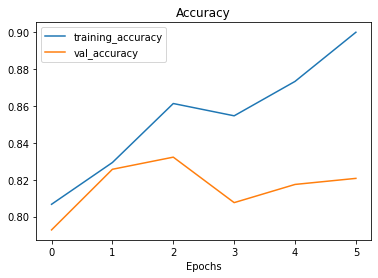

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
def compare_historys(orignal_history,new_history,initial_epochs = 5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = orignal_history.history["accuracy"]
    loss = orignal_history.history["loss"]

    val_acc = orignal_history.history["val_accuracy"]
    val_loss = orignal_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize = (8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc,label = "Training Accuracy")
    plt.plot(total_val_acc,label = "Validation Accuracy")
    plt.plot([initial_epochs - 1,initial_epochs - 1],
             plt.ylim(),label = "Start Fine tuning")
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')



    plt.subplot(2,1,2)
    plt.plot(total_loss,label = "Training Loss")
    plt.plot(total_val_loss,label = "Validation Loss")
    plt.plot([initial_epochs - 1,initial_epochs - 1],
             plt.ylim(),label = "Start Fine tuning")
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.show()


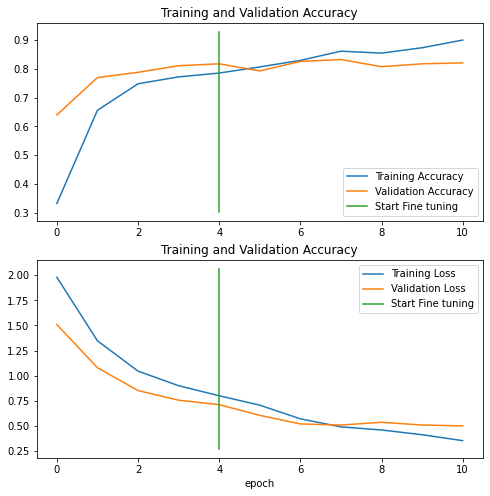

In [ ]:
compare_historys(orignal_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

# Model 4: Fine-tuning an existing model all of the data

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-05-19 18:59:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   126MB/s    in 4.1s    

2021-05-19 18:59:20 (120 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The testdata set we have loaded in is same as what we have been using for previous experiment (all experiment have used same test data set)

Let's verify it

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 15s 177ms/step - loss: 0.4813 - accuracy: 0.8348


[0.4813193380832672, 0.8348000049591064]

In [ ]:
result_fine_tune_10_percent

[0.48131924867630005, 0.8348000049591064]

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 15s 178ms/step - loss: 0.4813 - accuracy: 0.8348


[0.48131924867630005, 0.8348000049591064]

In [ ]:
result_fine_tune_10_percent

[0.48131924867630005, 0.8348000049591064]

To train a fine tune-model(model-4) we need to revert our model_2 back to it's feature extraction weights

In [ ]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 14s 176ms/step - loss: 0.6867 - accuracy: 0.8172


[0.6867193579673767, 0.8172000050544739]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentaion True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_9 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = ["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epoch = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epoch,
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           validation_data = test_data,
                                           validation_steps = int(0.25*len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210519-190016
Epoch 5/10
235/235 [==============================] - 67s 250ms/step - loss: 0.7778 - accuracy: 0.7554 - val_loss: 0.3491 - val_accuracy: 0.8931
Epoch 6/10
235/235 [==============================] - 65s 276ms/step - loss: 0.5979 - accuracy: 0.8077 - val_loss: 0.3113 - val_accuracy: 0.9095
Epoch 7/10
235/235 [==============================] - 64s 269ms/step - loss: 0.5265 - accuracy: 0.8324 - val_loss: 0.3491 - val_accuracy: 0.8849
Epoch 8/10
235/235 [==============================] - 63s 265ms/step - loss: 0.4965 - accuracy: 0.8383 - val_loss: 0.3148 - val_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 62s 262ms/step - loss: 0.4422 - accuracy: 0.8646 - val_loss: 0.3202 - val_accuracy: 0.8964
Epoch 10/10
235/235 [==============================] - 63s 265ms/step - loss: 0.4051 - accuracy: 0.8726 - val_loss: 0.2736 - val_accuracy: 0.9227


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 14s 176ms/step - loss: 0.3154 - accuracy: 0.9008


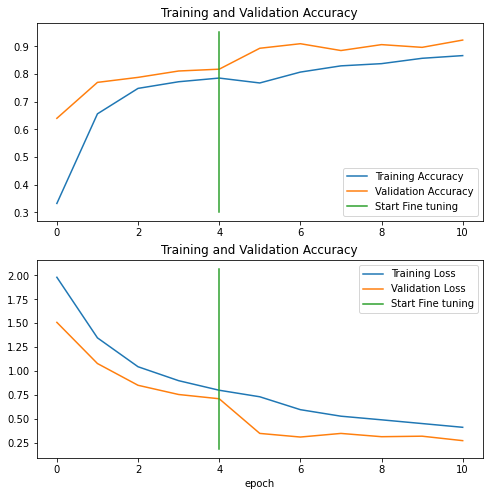

In [ ]:
# How did fine-tuning go with more data?
compare_historys(orignal_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

# Viewing our experiment data on TensorBoard

🔑 **Note**: Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer learning experiment"\
 --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning"\
 --one_shot # exits the uploader when upload has finished

2021-05-19 19:06:57.157268: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/tensorboard/uploader/server_info.py:129: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  return server_info_pb2.ServerInfoResponse.FromString(response.content)
E0519 19:06:59.295284 140106080962432 uploader_subcommand.py:126] Server info response: 
Internal error: frontend did not specify an API server
